In [1]:
#Initial configuration, probably overkill in imports.
import sys, os, re
import glob
import numpy as np
import allel
import zarr
import dask
import numcodecs
import warnings
from pathlib import Path
from horizonplot import horizonplot

#os.environ["MODIN_ENGINE"] = "ray"

#import modin.pandas as pd
import pandas as pd

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
sns.set_theme()
sns.set_style("white")
sns.set_context("notebook")

In [2]:
vcf_dir = "/faststorage/project/primatediversity/data/PGDP_16_7_2020/variants/"
vcf_suffix = ".variable.filtered.HF.snps.vcf.gz"
metadata = "/faststorage/project/primatediversity/data/PGDP_16_7_2020/metadata/PGDP_md.16.7.2020.xlsx"
#Getting permission denied

In [3]:
metadata_samples = pd.read_excel(metadata)

In [4]:
metadata_samples

,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID
0,PD_0001,Cheracebus,lugens,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.fasta
1,PD_0002,Callibella,humilis,FAIL,PASS,Callithrix_jacchus,Callithrix_jacchus.fasta
2,PD_0003,Cacajao,hosomi,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.bgi.fa
3,PD_0004,Ateles,belzebuth,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa
4,PD_0005,Alouatta,seniculus,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa
...,...,...,...,...,...,...,...
695,PD_0843,Trachypithecus,vetulus,PASS,PASS,Trachypithecus_phayrei,Trachypithecus_phayrei.fasta
696,PD_0844,Leontopithecus,chrysomelas,PASS,PASS,Callithrix_jacchus,Callithrix_jacchus.fasta
697,PD_0845,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta
698,PD_0846,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta


In [5]:
X_vs_A = glob.glob("/faststorage/project/primatediversity/data/PGDP_16_7_2020/metadata/*simplified.csv")
sex_via_cov = "/faststorage/project/primatediversity/data/PGDP_16_7_2020/metadata/sex_via_coverage_Lukas.csv"

#pd.read_csv("/faststorage/project/primatediversity/data/PGDP_16_7_2020/metadata/Pan_troglodytes_X_vs_A_simplified.csv", sep="\t")

In [6]:
d_cov = pd.read_csv(sex_via_cov)
d_cov[:-100]

,PGDP_ID,species,autosomal_coverage,X_coverage,X_over_autosome_ratio
0,PD_0001,Pithecia_pithecia.fasta,31,30,0.967742
1,PD_0002,Callithrix_jacchus.fasta,24,12,0.500000
2,PD_0003,Pithecia_pithecia.fasta,30,16,0.533333
3,PD_0004,Atele_fusciceps.fasta,31,31,1.000000
4,PD_0005,Atele_fusciceps.fasta,30,15,0.500000
...,...,...,...,...,...
573,PD_0848,Rhinopithecus_roxellana.fasta,34,17,0.500000
574,PD_0849,Trachypithecus_phayrei.fasta,31,15,0.483871
575,PD_0850,Trachypithecus_phayrei.fasta,21,9,0.428571
576,PD_0851,Trachypithecus_phayrei.fasta,39,19,0.487179


In [7]:
hetero = "/faststorage/project/primatediversity/data/PGDP_16_7_2020/metadata/sex_Marjo_heterozygosity.csv"
d_hetero = pd.read_csv(hetero, "\t")
d_hetero.reference_file.unique()

array(['Atele_fusciceps.fasta', 'Aotus_nancymaae.fasta',
       'Pithecia_pithecia.fasta', 'Cebus_albifrons.fasta',
       'Cercopithecus_mitis.fasta', 'Gorilla_gorilla_gorilla.fasta',
       'Hoolock_hoolock.fasta', 'Macaca_mulatta.fasta',
       'Nycticebus_pygmaeus.fasta', 'Pan_troglodytes.fasta',
       'rheMac10.fa', nan, 'Papio_anubis.fasta',
       'Pygathrix_nemaeus.fasta', 'Sapajus_apella.fasta',
       'Rhinopithecus_roxellana.fasta', 'Trachypithecus_phayrei.fasta'],
      dtype=object)

The following code counts het sites for each individual over the whole X.
Has various if-statements to avoid errors, as well as handle cases wherein the X is spread over multiple contigs.

In [8]:
simplified_csv = "/faststorage/project/primatediversity/data/PGDP_16_7_2020/metadata/{}_X_vs_A_simplified.csv"

def count_het_species(d, genus):
    X_vs_A = simplified_csv.format(genus[:-6])
    contigs = pd.read_csv(X_vs_A, sep="\t")
    x_contigs = contigs.loc[contigs.decision == "X"].scaffold.values
    het_count = []
    ID_list = []
    sex = []
    species_list = []
    ref_list = []
    for i, row in d.iterrows():
        ID = row.PDGP_ID
        ID_list.append(ID)
        sex.append(row.sex_coverage)
        species_list.append(row.full_spec_name)
        ref_list.append(row.reference_file)
        het_total = 0
        for contig in x_contigs:
            path = vcf_dir+ID+vcf_suffix
            if os.path.exists(path):
                vcf_callset = allel.read_vcf(path, region=contig, fields=["calldata/GT"])
                if vcf_callset != None:
                    gt = allel.GenotypeArray(vcf_callset["calldata/GT"])
                    het_total += gt.count_het()
                else:
                    print(contig, ID)
            else:
                print(ID)
        het_count.append(het_total)
    d={"PDGP_ID": ID_list, "sex": sex, "species": species_list, "total_het": het_count, "ref": ref_list}
    df = pd.DataFrame(data=d)
    return df

df_list = []
for genus in d_hetero.reference_file.unique():
    d = d_hetero.loc[d_hetero.reference_file == genus]
    if genus not in ["rheMac10.fa", "Papio_anubis.fasta"] and len(d) > 0:
        df = count_het_species(d, genus)
        if len(df) > 0:
            df_list.append(df)
primate_df = pd.concat(df_list)

tarseq_214 PD_0001
tarseq_56 PD_0001
tarseq_87 PD_0001
Contig110 PD_0368


In [9]:
primate_df

,PDGP_ID,sex,species,total_het,ref
0,PD_0422,female,Alouatta_juara,38260,Atele_fusciceps.fasta
1,PD_0423,male,Alouatta_juara,12819,Atele_fusciceps.fasta
2,PD_0136,male,Alouatta_juara,26473,Atele_fusciceps.fasta
3,PD_0072,female,Alouatta_juara,51272,Atele_fusciceps.fasta
4,PD_0426,male,Alouatta_juara,10824,Atele_fusciceps.fasta
...,...,...,...,...,...
1,PD_0598,male,Trachypithecus_geei,11921,Trachypithecus_phayrei.fasta
2,PD_0599,male,Trachypithecus_geei,12458,Trachypithecus_phayrei.fasta
3,PD_0600,male,Trachypithecus_geei,11218,Trachypithecus_phayrei.fasta
4,PD_0595,male,Trachypithecus_geei,14513,Trachypithecus_phayrei.fasta


In [10]:
for species in primate_df.species.unique():
    print(species, len(primate_df.loc[primate_df.species==species]))

Alouatta_juara 5
Alouatta_seniculus 17
Ateles_chamek 8
Aotus_azarae 14
Aotus_griseimembra 4
Aotus_vociferans 5
Cacajao_calvus 13
Cacajao_sp. 5
Cheracebus_lucifer 4
Cheracebus_lugens 8
Chiropotes_albinasus 6
Chiropotes_israelita 4
Plecturocebus_cupreus 5
Cebus_albifrons 5
Saimiri_cassiquiarensis 9
Saimiri_ustus 6
Cercopithecus_ascanius 4
Gorilla_gorilla 16
Hoolock_hoolock 9
Macaca_arctoides 4
Macaca_fascicularis 23
Macaca_leonina 6
Macaca_mulatta 6
Macaca_radiata 13
Macaca_silenus 12
Nycticebus_bengalensis 4
Pan_troglodytes 4
Pygathrix_cinerea 5
Pygathrix_nemaeus 5
Sapajus_apella 5
Sapajus_macrocephalus 5
Sapajus_sp. 4
Semnopithecus_entellus 6
Semnopithecus_hypoleucos 4
Trachypithecus_geei 6


In [11]:
print(d_hetero.reference_file.unique())
for genus in primate_df.ref.unique():
    print(genus, len(primate_df.loc[primate_df.ref==genus]))

['Atele_fusciceps.fasta' 'Aotus_nancymaae.fasta' 'Pithecia_pithecia.fasta'
 'Cebus_albifrons.fasta' 'Cercopithecus_mitis.fasta'
 'Gorilla_gorilla_gorilla.fasta' 'Hoolock_hoolock.fasta'
 'Macaca_mulatta.fasta' 'Nycticebus_pygmaeus.fasta'
 'Pan_troglodytes.fasta' 'rheMac10.fa' nan 'Papio_anubis.fasta'
 'Pygathrix_nemaeus.fasta' 'Sapajus_apella.fasta'
 'Rhinopithecus_roxellana.fasta' 'Trachypithecus_phayrei.fasta']
Atele_fusciceps.fasta 30
Aotus_nancymaae.fasta 23
Pithecia_pithecia.fasta 45
Cebus_albifrons.fasta 20
Cercopithecus_mitis.fasta 4
Gorilla_gorilla_gorilla.fasta 16
Hoolock_hoolock.fasta 9
Macaca_mulatta.fasta 64
Nycticebus_pygmaeus.fasta 4
Pan_troglodytes.fasta 4
Pygathrix_nemaeus.fasta 10
Sapajus_apella.fasta 14
Rhinopithecus_roxellana.fasta 10
Trachypithecus_phayrei.fasta 6


<AxesSubplot:xlabel='total_het', ylabel='Count'>

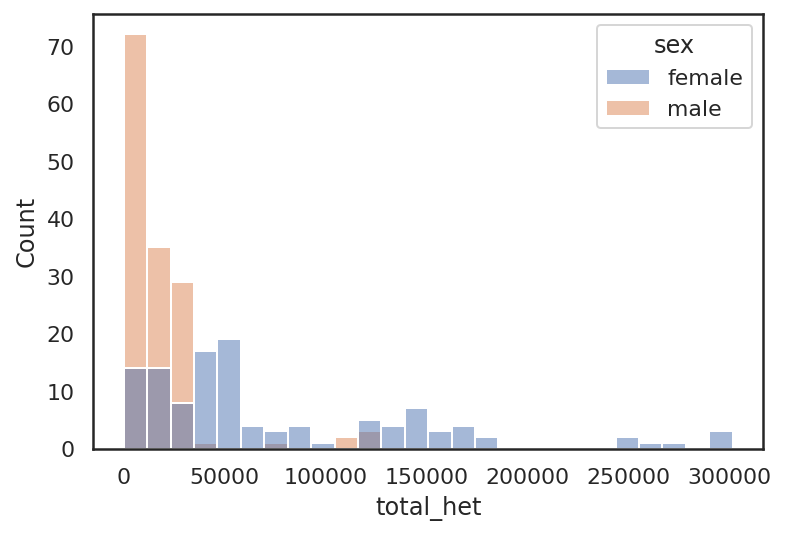

In [12]:
fig = sns.histplot(data=primate_df, x="total_het", hue="sex", )
fig

Atele_fusciceps.fasta
Aotus_nancymaae.fasta
Pithecia_pithecia.fasta
Cebus_albifrons.fasta
Cercopithecus_mitis.fasta
Gorilla_gorilla_gorilla.fasta
Hoolock_hoolock.fasta
Macaca_mulatta.fasta
Nycticebus_pygmaeus.fasta
Pan_troglodytes.fasta
Pygathrix_nemaeus.fasta
Sapajus_apella.fasta
Rhinopithecus_roxellana.fasta
Trachypithecus_phayrei.fasta


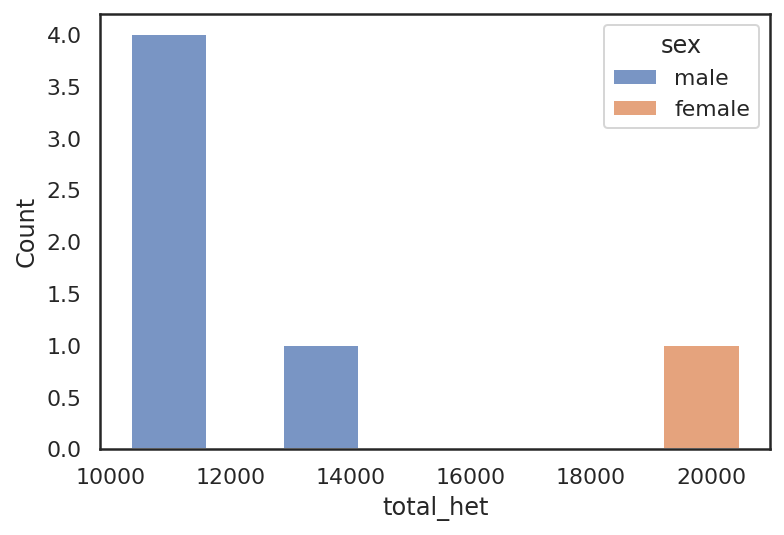

In [13]:
for genus in primate_df.ref.unique():
    g_df = primate_df.loc[primate_df.ref==genus]
    print(genus)
    plt.close()
    fig = sns.histplot(data=g_df, x="total_het", hue="sex", multiple="dodge")
    fig = fig.get_figure()
    fig.savefig("../results/{}_m_vs_f.png".format(genus))
    fig

The following code is used to the heterozygosity of windows.
#Note: As the dataset is not unified, window numbers varies. In addition, some contigs are missing

In [14]:
simplified_csv = "/faststorage/project/primatediversity/data/PGDP_16_7_2020/metadata/{}_X_vs_A_simplified.csv"

window_size = 100000
def het_counting(gt):
    return gt.count_het()

def count_het_species(d, genus):
    X_vs_A = simplified_csv.format(genus[:-6])
    print(genus)
    contigs = pd.read_csv(X_vs_A, sep="\t")
    x_contigs = contigs.loc[contigs.decision == "X"].scaffold.values
    df_list_species = []
    for i, row in d.iterrows():
        df = pd.DataFrame()
        het_list = []
        ID = row.PDGP_ID
        for contig in x_contigs:
            path = vcf_dir+ID+vcf_suffix
            if os.path.exists(path):
                vcf_callset = allel.read_vcf(path, region=contig, fields=["calldata/GT", "variants/POS"])
                if vcf_callset != None:
                    gt = allel.GenotypeArray(vcf_callset["calldata/GT"])
                    pos = vcf_callset["variants/POS"]
                    nnz, windows, counts = allel.windowed_statistic(
                        pos, gt, statistic=het_counting, size=window_size)
                    het_list.extend(nnz)
                else:
                    print(contig, ID)
            else:
                print(ID)
        df["het"] = het_list
        window_numbering = []
        window_numbering.extend(range(len(het_list)))
        df.insert(1, column="window", value=window_numbering)
        df.insert(2, column = "PGDP_ID", value = ID)
        df.insert(3, column = "genus", value = genus[:-6])
        df.insert(3, column = "species", value = row.full_spec_name)
        df_list_species.append(df)
    df = pd.concat(df_list_species, ignore_index=False)
    return df

df_list = []
for genus in d_hetero.reference_file.unique():
    d = d_hetero.loc[d_hetero.reference_file == genus]
    if genus not in ["rheMac10.fa", "Papio_anubis.fasta"] and len(d) > 0:
        df = count_het_species(d, genus)
        if len(df) > 0:
            df_list.append(df)
primate_df = pd.concat(df_list, ignore_index=False)
primate_df.to_csv("../steps/het_counts_windows_primates_x.txt", sep = " ", index=False)

Atele_fusciceps.fasta
Aotus_nancymaae.fasta
Pithecia_pithecia.fasta
tarseq_214 PD_0001
tarseq_56 PD_0001
tarseq_87 PD_0001
Cebus_albifrons.fasta
Contig110 PD_0368
Cercopithecus_mitis.fasta
Gorilla_gorilla_gorilla.fasta
Hoolock_hoolock.fasta
Macaca_mulatta.fasta
Nycticebus_pygmaeus.fasta
Pan_troglodytes.fasta
Pygathrix_nemaeus.fasta
Sapajus_apella.fasta
Rhinopithecus_roxellana.fasta
Trachypithecus_phayrei.fasta


In [15]:
primate_df.rename(columns = {"window": "start", "PGDP_ID": "pop"}, inplace=True)
primate_df["chrom"] = "chrX"
primate_df

,het,start,pop,species,genus,chrom
0,12.0,0,PD_0422,Alouatta_juara,Atele_fusciceps,chrX
1,16.0,1,PD_0422,Alouatta_juara,Atele_fusciceps,chrX
2,50.0,2,PD_0422,Alouatta_juara,Atele_fusciceps,chrX
3,13.0,3,PD_0422,Alouatta_juara,Atele_fusciceps,chrX
4,42.0,4,PD_0422,Alouatta_juara,Atele_fusciceps,chrX
...,...,...,...,...,...,...
980,7.0,980,PD_0596,Trachypithecus_geei,Trachypithecus_phayrei,chrX
981,2.0,981,PD_0596,Trachypithecus_geei,Trachypithecus_phayrei,chrX
982,2.0,982,PD_0596,Trachypithecus_geei,Trachypithecus_phayrei,chrX
983,28.0,983,PD_0596,Trachypithecus_geei,Trachypithecus_phayrei,chrX


Comparing median and means - hard to detect differences.

Atele_fusciceps
Aotus_nancymaae
Pithecia_pithecia
Cebus_albifrons
Cercopithecus_mitis
Gorilla_gorilla_gorilla
Hoolock_hoolock
Macaca_mulatta
Nycticebus_pygmaeus
Pan_troglodytes
Pygathrix_nemaeus
Sapajus_apella
Rhinopithecus_roxellana
Trachypithecus_phayrei


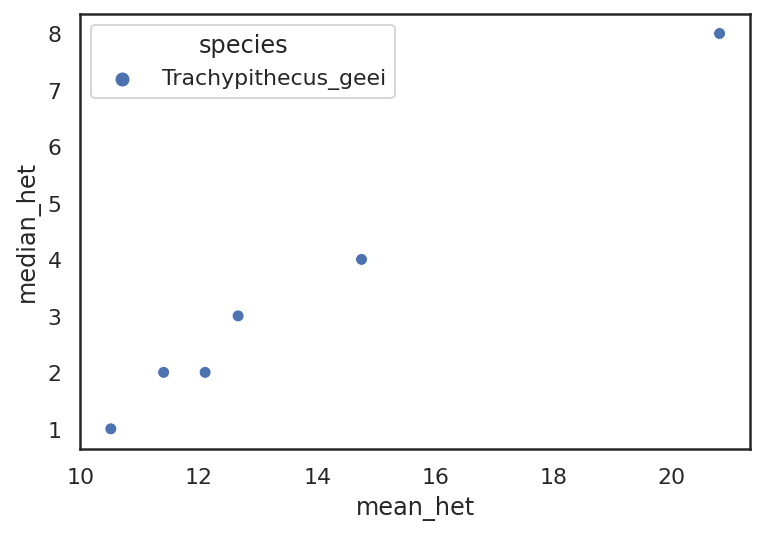

In [42]:
for genus in primate_df.genus.unique():
    genus_df = primate_df.loc[primate_df.genus == genus]
    print(genus)
    mean_l = []
    median_l = []
    ID_l = []
    s_l = []
    IDs = genus_df["pop"].unique()
    for ID in IDs:
        id_df = genus_df.loc[genus_df["pop"] == ID]
        ID_l.append(ID)
        s_l.append(id_df.species[0])
        mean_l.append(id_df["het"].mean())
        median_l.append(id_df["het"].median())
    d={"PDGP_ID": ID_l, "mean_het": mean_l, "median_het": median_l, "species": s_l}
    df = pd.DataFrame(data=d)
    plt.close()
    fig = sns.scatterplot(data=df, x="mean_het", y="median_het", hue="species")
    fig = fig.get_figure()
    fig.savefig("../results/{}_median_mean.png".format(genus))
    fig

Doing the same, but with upper quartile to hopefully distinguish it better

Atele_fusciceps
Aotus_nancymaae
Pithecia_pithecia
Cebus_albifrons
Cercopithecus_mitis
Gorilla_gorilla_gorilla
Hoolock_hoolock
Macaca_mulatta
Nycticebus_pygmaeus
Pan_troglodytes
Pygathrix_nemaeus
Sapajus_apella
Rhinopithecus_roxellana
Trachypithecus_phayrei


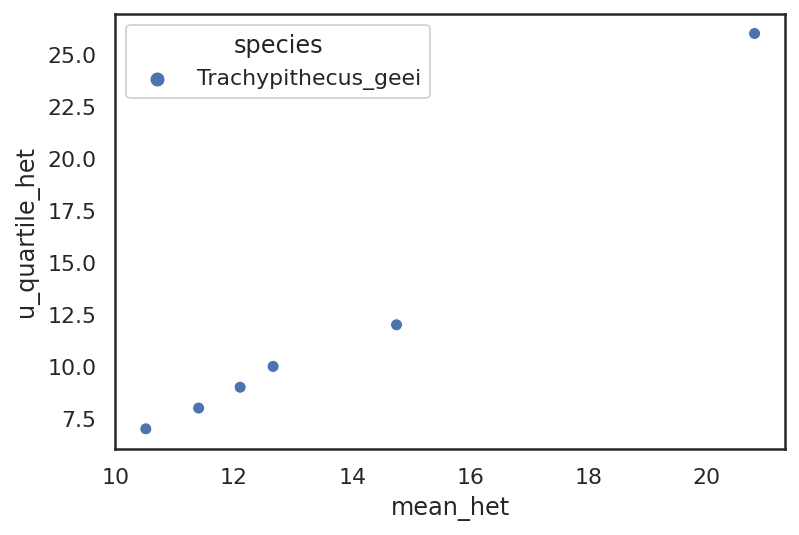

In [43]:
for genus in primate_df.genus.unique():
    genus_df = primate_df.loc[primate_df.genus == genus]
    print(genus)
    mean_l = []
    quartile_l = []
    ID_l = []
    s_l = []
    IDs = genus_df["pop"].unique()
    for ID in IDs:
        id_df = genus_df.loc[genus_df["pop"] == ID]
        ID_l.append(ID)
        s_l.append(id_df.species[0])
        mean_l.append(id_df["het"].mean())
        quartile_l.append(id_df["het"].quantile(0.75))
    d={"PDGP_ID": ID_l, "mean_het": mean_l, "u_quartile_het": quartile_l, "species": s_l}
    df = pd.DataFrame(data=d)
    plt.close()
    fig = sns.scatterplot(data=df, x="mean_het", y="u_quartile_het", hue="species")
    fig = fig.get_figure()
    fig.savefig("../results/{}_u_quartile_mean.png".format(genus))
    fig

Finding genus that only has 1 contig mapping to X, and making horizonplots for those

In [25]:
for genus in primate_df.genus.unique():
    X_vs_A = simplified_csv.format(genus)
    contigs = pd.read_csv(X_vs_A, sep="\t")
    x_contigs = contigs.loc[contigs.decision == "X"].scaffold.values
    if len(x_contigs) == 1:
        print(genus)

Gorilla_gorilla_gorilla
Macaca_mulatta
Pan_troglodytes
Pygathrix_nemaeus
Rhinopithecus_roxellana


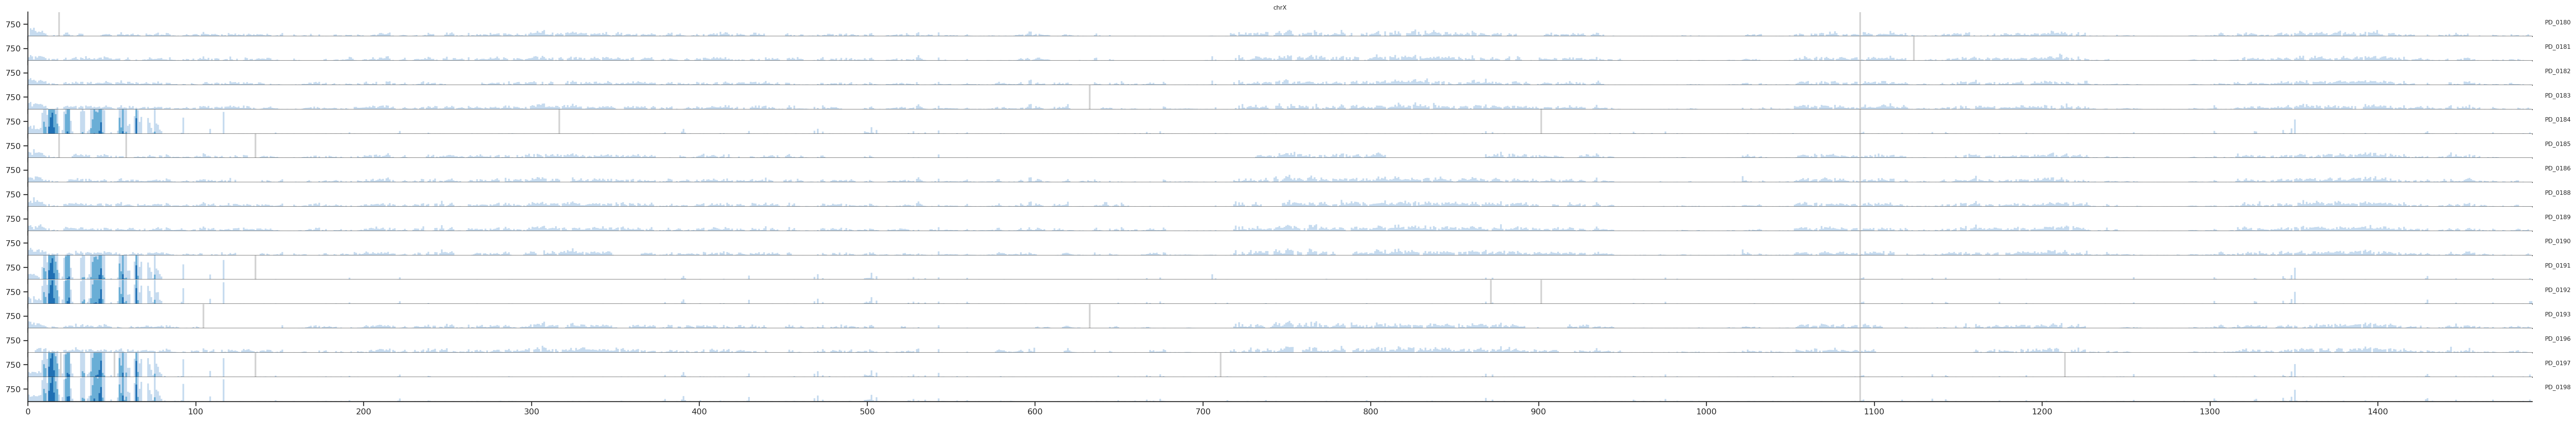

In [26]:
genus= "Gorilla_gorilla_gorilla"
genus_df = primate_df.loc[primate_df.genus == genus]
fig = horizonplot(genus_df, 'het', width=1, row='pop', size=0.5, aspect=100)
fig.savefig("../results/{}_horizonplot.png".format(genus))

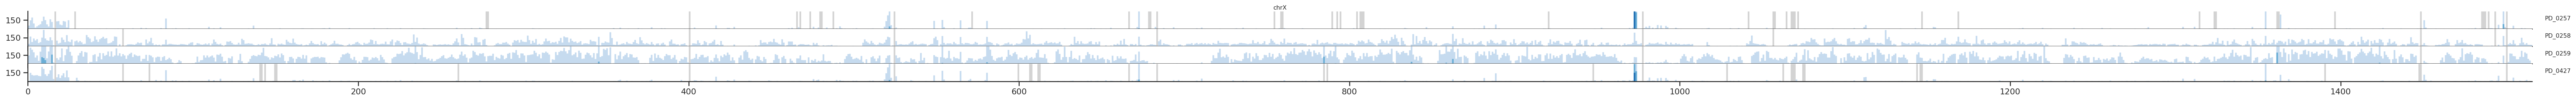

In [27]:
genus= "Pan_troglodytes"
genus_df = primate_df.loc[primate_df.genus == genus]
fig = horizonplot(genus_df, 'het', width=1, row='pop', size=0.5, aspect=100)
fig.savefig("../results/{}_horizonplot.png".format(genus))

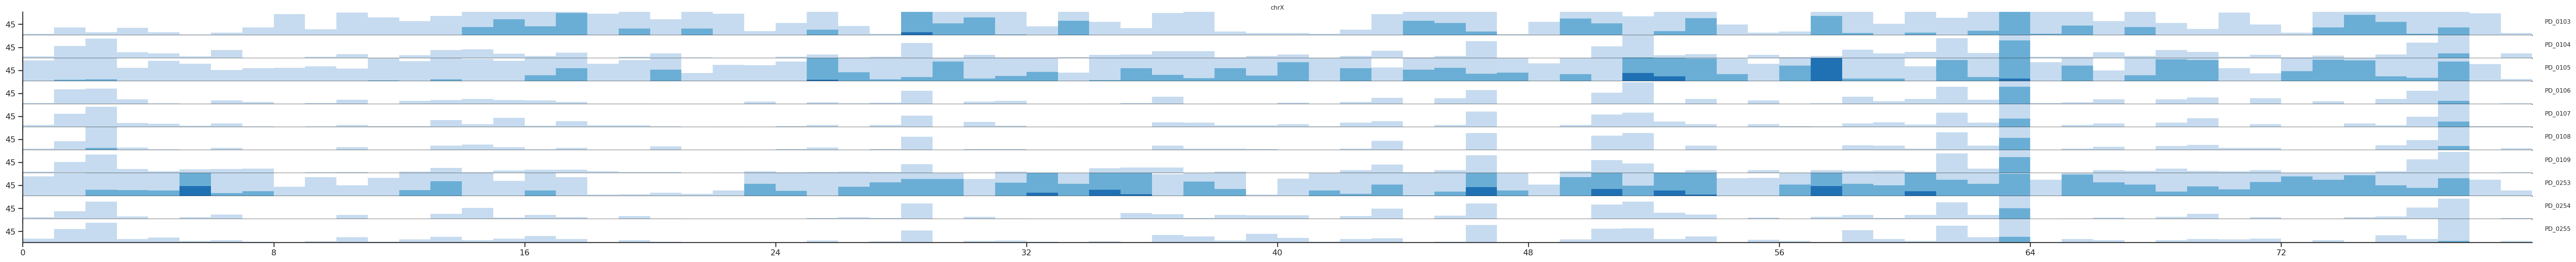

In [28]:
genus= "Pygathrix_nemaeus"
genus_df = primate_df.loc[primate_df.genus == genus]
fig = horizonplot(genus_df, 'het', width=1, row='pop', size=0.5, aspect=100)
fig.savefig("../results/{}_horizonplot.png".format(genus))

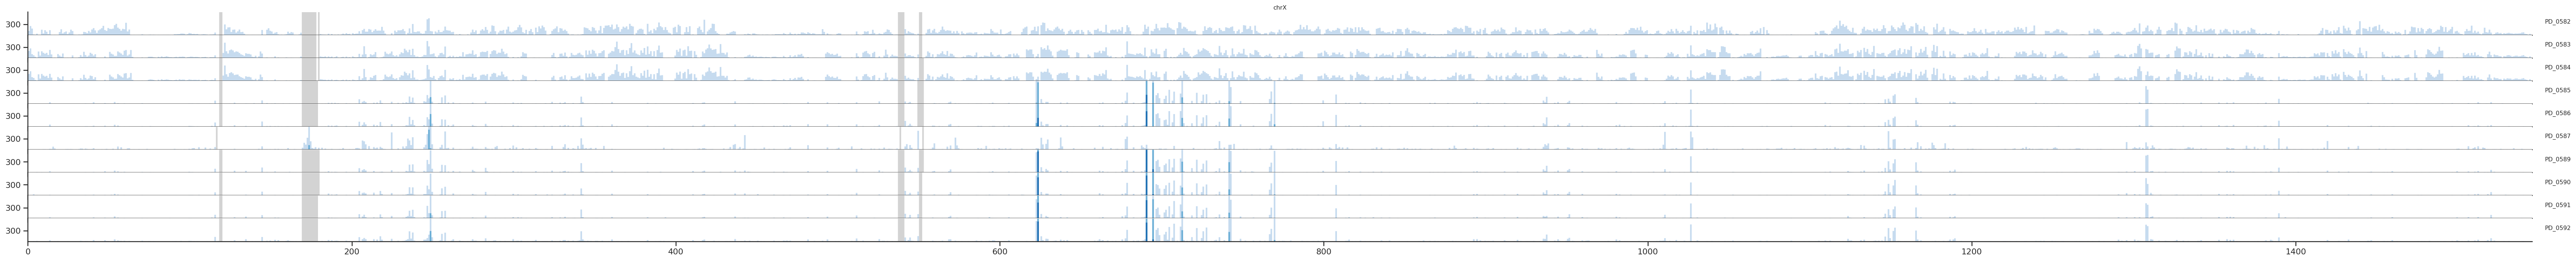

In [29]:
genus= "Rhinopithecus_roxellana"
genus_df = primate_df.loc[primate_df.genus == genus]
fig = horizonplot(genus_df, 'het', width=1, row='pop', size=0.5, aspect=100)
fig.savefig("../results/{}_horizonplot.png".format(genus))

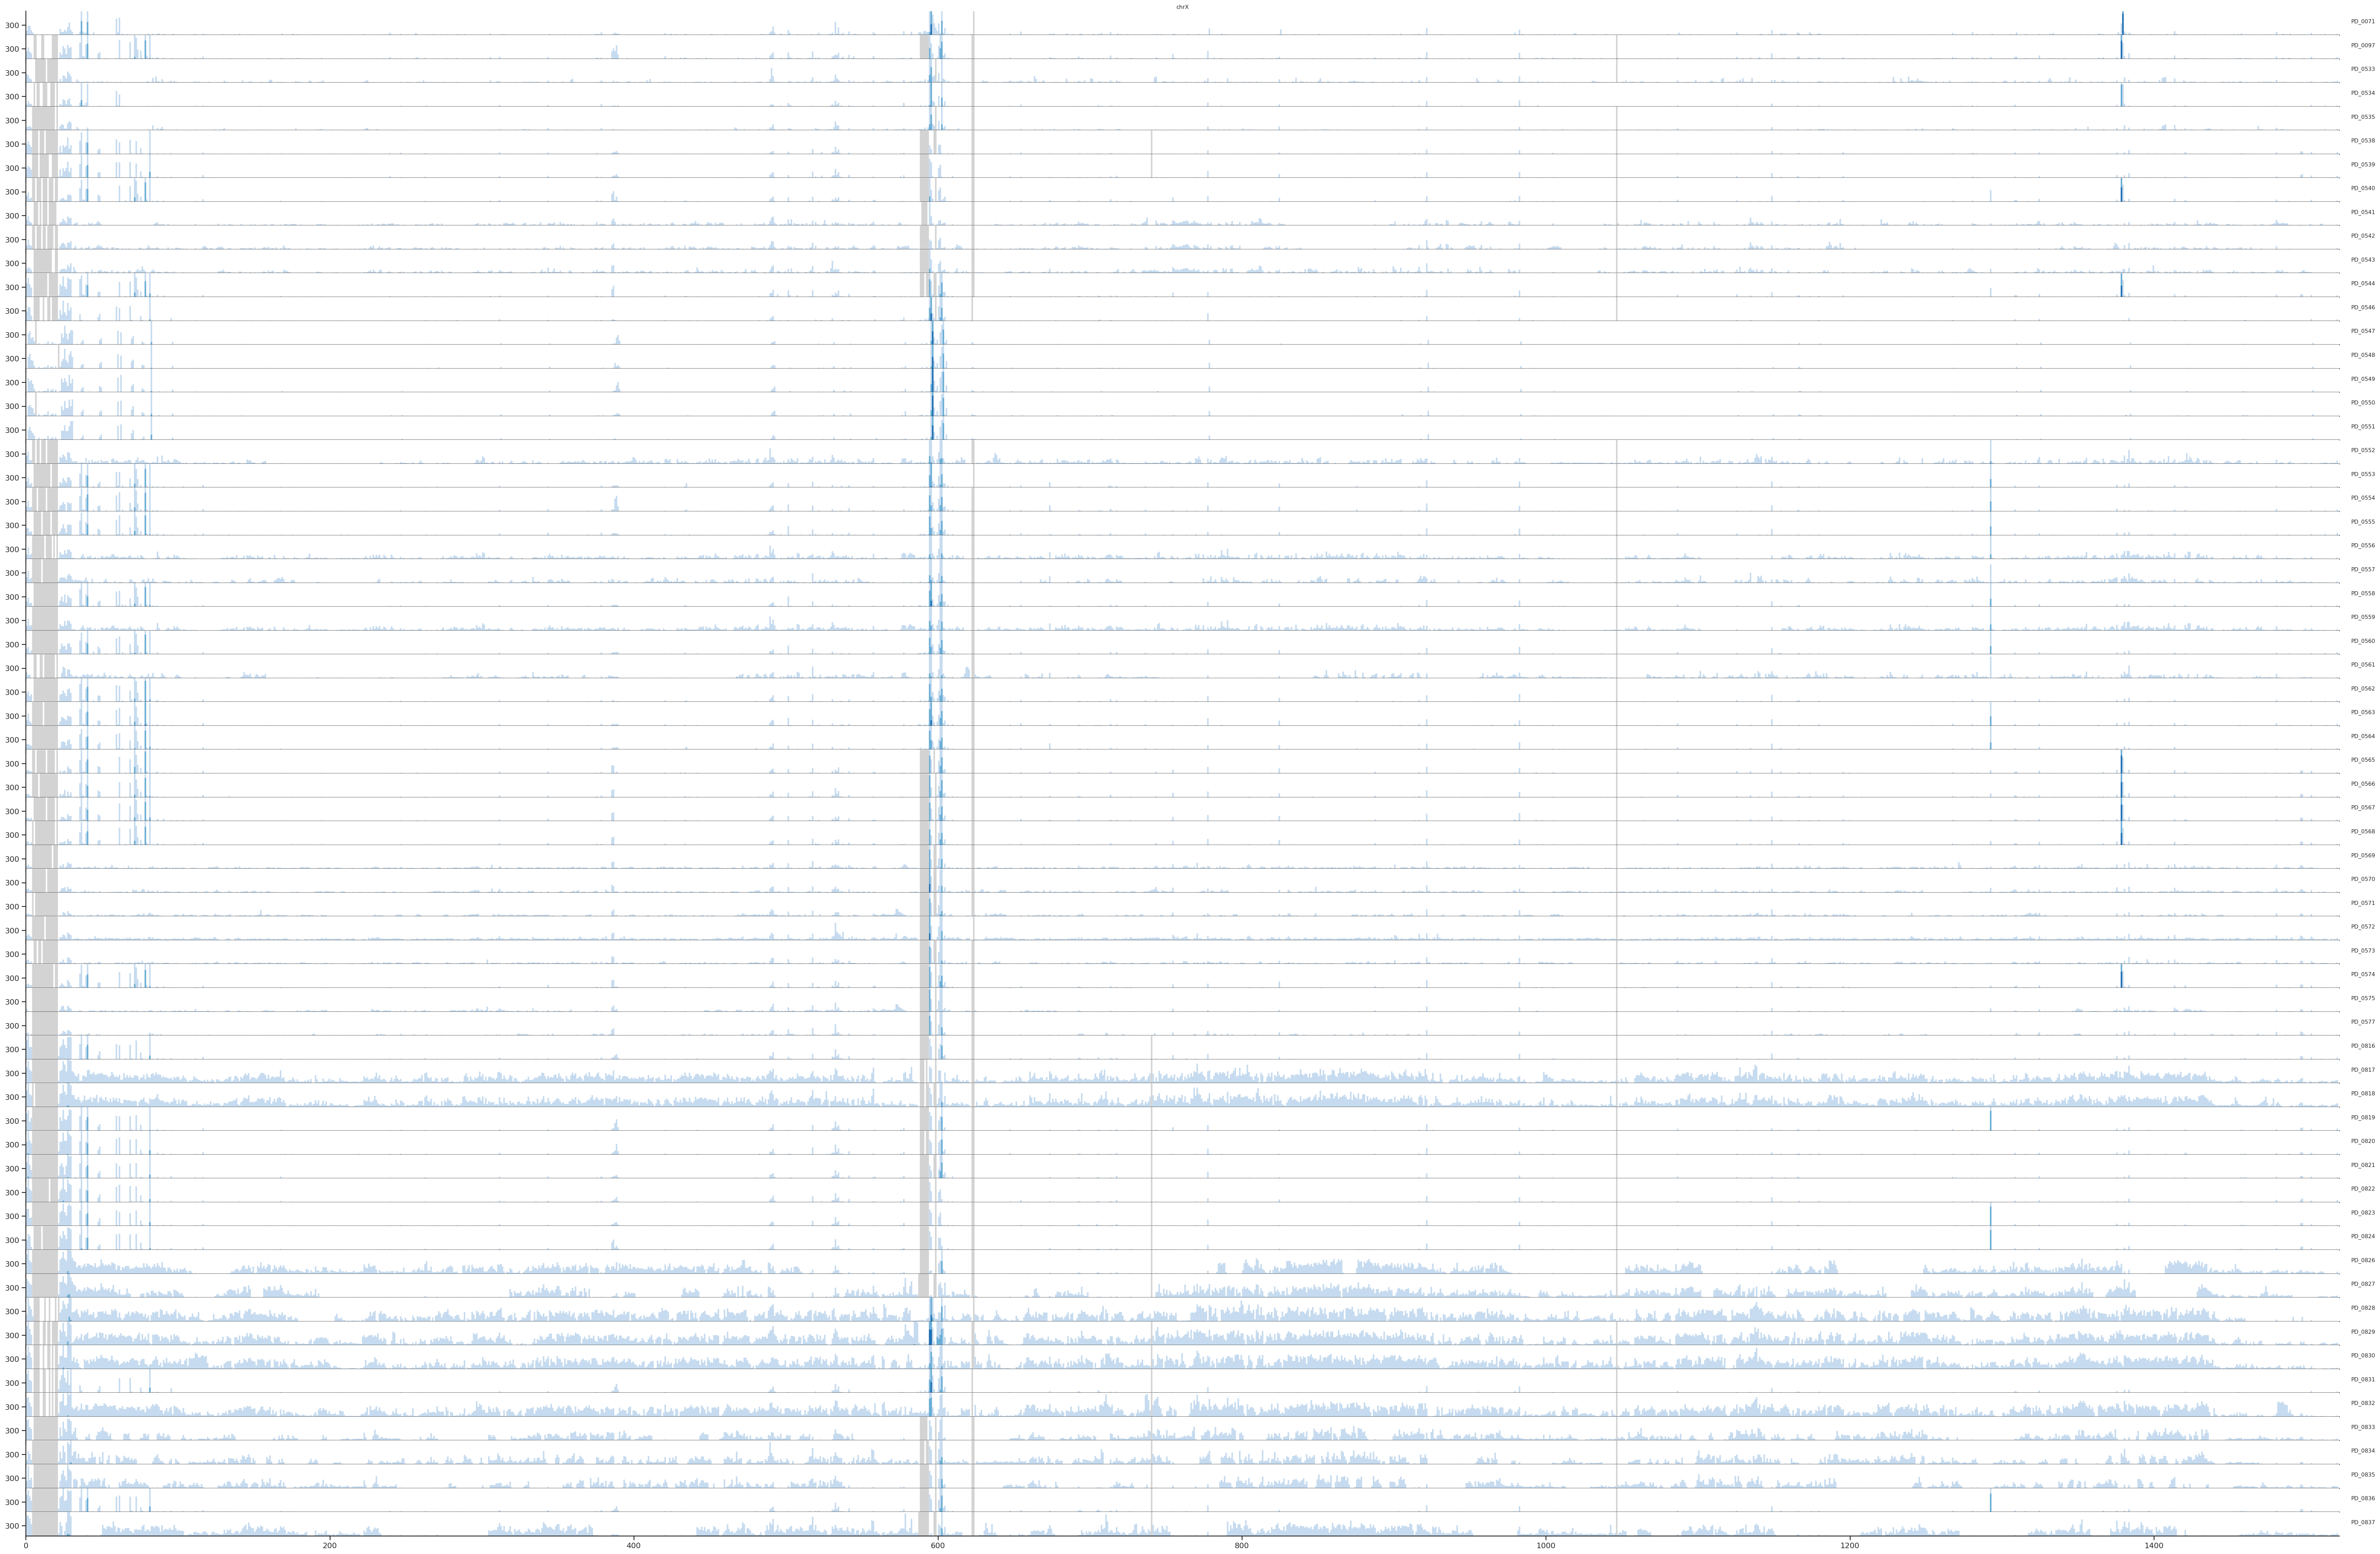

In [30]:
genus= "Macaca_mulatta"
genus_df = primate_df.loc[primate_df.genus == genus]
fig = horizonplot(genus_df, 'het', width=1, row='pop', size=0.5, aspect=100)
fig.savefig("../results/{}_horizonplot.png".format(genus))

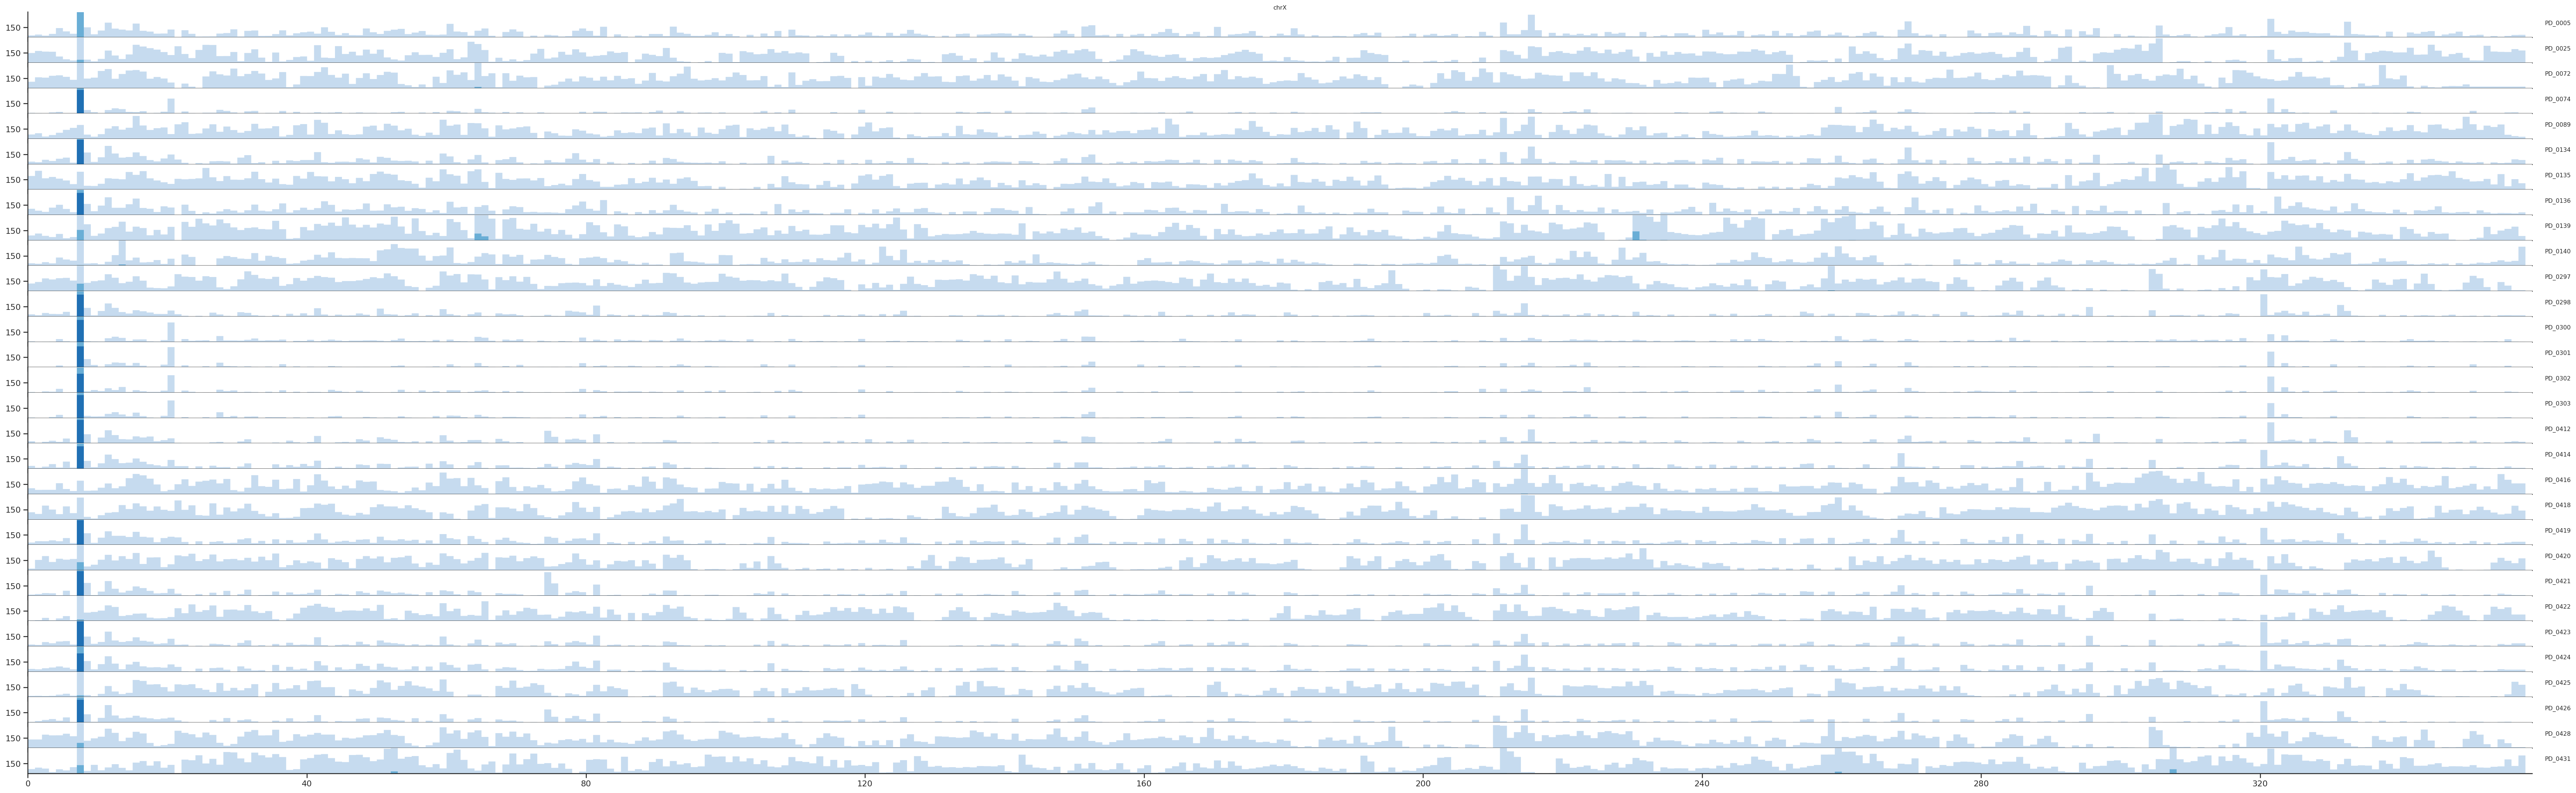

In [47]:
genus= "Atele_fusciceps"
genus_df = primate_df.loc[primate_df.genus == genus]
fig = horizonplot(genus_df, 'het', width=1, row='pop', size=0.5, aspect=100)
fig.savefig("../results/{}_horizonplot.png".format(genus))

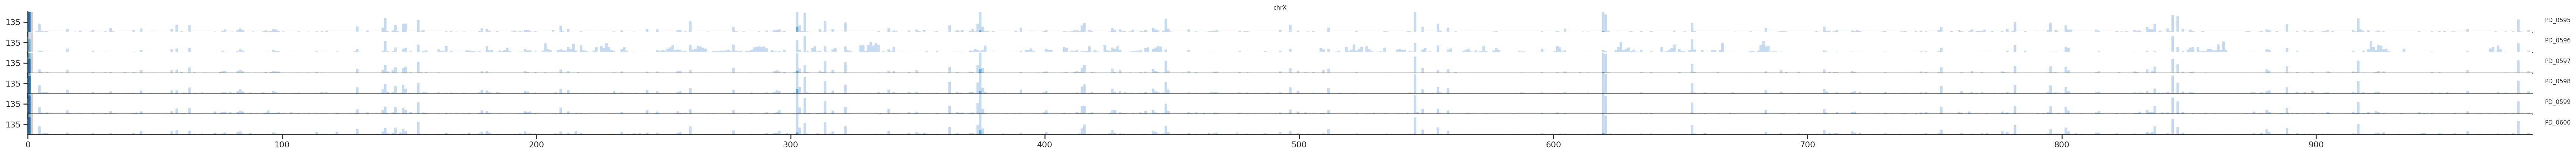

In [48]:
for genus in primate_df.genus.unique():
    genus_df = primate_df.loc[primate_df.genus == genus]
    plt.close()
    fig = horizonplot(genus_df, 'het', width=1, row='pop', size=0.5, aspect=100)
    fig.savefig("../results/{}_horizonplot.png".format(genus))

does_not_exist = []
no_chrx = []
has_chrx = []
for i in range(100, 848):
    if i % 10 == 0:
        print(i)
    ID = "PD_0{}".format(i)
    path = vcf_dir+ID+vcf_suffix
    if os.path.exists(path):
        vcf_callset = allel.read_vcf(path, region="chrX", fields=["calldata/GT", "variants/POS"])
        if vcf_callset == None:
            no_chrx.append(ID)
        else:
            has_chrx.append(ID)
    else:
        does_not_exist.append(ID)